In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import (
    dynamic_feature_last_position_taken,
    dynamic_feature_real_position  # you can import it if you ever need it
)

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    nonstationary_prob_model, 
    make_ohlc,
    FeatureEngineering,
    excess_return_metric,
    extract_signals,
)
from RLTrade.plot_utils import (
    build_fig,
    plot_signals_distribution,
)

In [2]:
x0, mu_epsilon = 100, 200

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

train_set_random_state = 42
x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=train_set_random_state)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
# spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 5,  # sidetrack: the rolling window mean correction can somehow help detect mean shift
       'mode': 'diff',
     }},
]

fe = FeatureEngineering(df)
df_train = fe.build_features(feature_config)

# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_prob_model",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1.]
Market Return :  7.31%   |   Portfolio Return : -19.02%   |   Excess Return : -28.93%   |   Position Changes : 2733   |   Episode Length : 4166   |   


In [3]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations, n_actions)

for i_simulation in range(50):
    x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i_simulation*4201)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk
    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    df_train = fe.df.copy()

    # Define the environment
    env = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = df_train, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            # max_episode_duration=180
        )
    env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    history_metrics, _ = agent.train(env, num_episodes=1) # One episode is one simulation

Market Return : -4.51%   |   Portfolio Return : -15.31%   |   Excess Return : -12.42%   |   Position Changes : 2438   |   Episode Length : 4166   |   
Market Return : 25.16%   |   Portfolio Return : -0.32%   |   Excess Return : -23.18%   |   Position Changes : 2623   |   Episode Length : 4166   |   
Market Return : -7.15%   |   Portfolio Return : -1.70%   |   Excess Return : 4.79%   |   Position Changes : 2587   |   Episode Length : 4166   |   
Market Return : -2.85%   |   Portfolio Return :  9.77%   |   Excess Return : 11.61%   |   Position Changes : 2252   |   Episode Length : 4166   |   
Market Return : -4.44%   |   Portfolio Return : 20.27%   |   Excess Return : 22.47%   |   Position Changes : 2060   |   Episode Length : 4166   |   
Market Return :  4.30%   |   Portfolio Return : 35.63%   |   Excess Return : 25.72%   |   Position Changes : 2037   |   Episode Length : 4166   |   
Market Return : -17.14%   |   Portfolio Return : 25.50%   |   Excess Return : 40.77%   |   Position Chan

In [4]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100
all_metrics

,Market Return,Portfolio Return,Excess Return,Position Changes,Episode Length,episodic_reward
0,26.40%,8.04%,-16.04%,2010,4166,0.077343


In [5]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_prob_model_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -4.51%   |   Portfolio Return : 85.23%   |   Excess Return : 65.6%   |   Position Changes : 2255   |   Episode Length : 4166   |   
Market Return : -10.55%   |   Portfolio Return : 63.32%   |   Excess Return : 59.45%   |   Position Changes : 2261   |   Episode Length : 4166   |   
Market Return : -13.03%   |   Portfolio Return : 121.81%   |   Excess Return : 92.92%   |   Position Changes : 2250   |   Episode Length : 4166   |   
Market Return : -14.90%   |   Portfolio Return : 179.73%   |   Excess Return : 116.77%   |   Position Changes : 2177   |   Episode Length : 4166   |   
Market Return : -0.59%   |   Portfolio Return : 56.40%   |   Excess Return : 43.88%   |   Position Changes : 2265   |   Episode Length : 4166   |   
Market Return : 25.96%   |   Portfolio Return : 39.20%   |   Excess Return : 9.38%   |   Position Changes : 2240   |   Episode Length : 4166   |   
Market Return :  3.77%   |   Portfolio Return : 67.66%   |   Excess Return : 47.21%   |   Position Cha

In [6]:
historical_info_df = history_dfs[-1]
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_close', 'data_high', 'data_volume', 'data_open', 'data_low',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [7]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

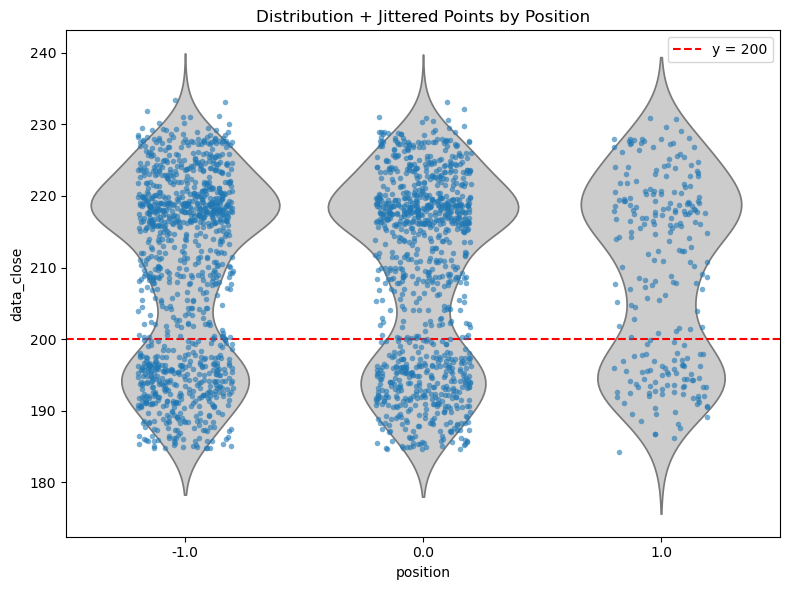

In [8]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

In [9]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > mu_epsilon
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,358,723
0.0,331,664
1.0,80,159
